In [421]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import logging

from sklearn.preprocessing import StandardScaler

from scipy.stats import skew, kurtosis

from utils.general import *

import json

import warnings

In [422]:
warnings.filterwarnings('ignore')

In [423]:
random_state = 42
rng = np.random.default_rng(random_state)

# Data Loading And Preprocessing

In [424]:
billboard_df = pd.read_csv("../data/billboard/hot-100_all.csv")
spotify_df = pd.read_csv("../data/spofity/songs.csv")
audio_analysis_df = pd.read_csv("../data/audio/audio_features_full.csv")

In [425]:
billboard_df.drop(axis=1, inplace=True, labels=['image', 'artist'])
billboard_df['date'] = pd.to_datetime(billboard_df['date'])
spotify_df.drop(axis=1, inplace=True, labels=['spotify_name',
                                              'artist',
                                              'artist_genres',
                                              'spotify_id',
                                              'spotify_id',
                                              'spotify_uri',
                                              'spotify_external_url',
                                              'spotify_artist_popularity',
                                              'preview_url',
                                              'preview_url_audio',
                                              'full_audio',
                                              'full_audio_duration_s'
                                              ])
audio_analysis_df.drop(axis=1, inplace=True, labels=['name', 'tempo'])

In [426]:
songs_df = spotify_df.merge(audio_analysis_df, how='inner', on='billboard_name')
songs_df

,billboard_name,duration_ms,spotify_popularity,spotify_artist_popularity_mean,explicit,danceability,energy,key,loudness,mode,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,All I Want For Christmas Is You,241106.0,69.0,81.000000,False,0.336,0.627,7.0,-7.463,1.0,...,1.619618,99.735660,-3.865835,99.024666,2.729783,112.219580,-7.488522,122.569650,2.323859,141.572560
1,Rockin' Around The Christmas Tree,126266.0,62.0,59.000000,False,0.589,0.472,8.0,-8.749,1.0,...,-1.039626,78.420586,-4.437555,55.536427,3.890496,70.359543,0.014326,77.899239,6.889563,93.610161
2,Jingle Bell Rock,130973.0,62.0,50.000000,False,0.754,0.424,2.0,-8.463,1.0,...,1.430321,58.685158,-4.030815,67.332291,1.802275,58.469532,-5.335912,53.423290,0.133941,58.774597
3,A Holly Jolly Christmas,135533.0,54.0,48.000000,False,0.683,0.375,0.0,-13.056,1.0,...,-1.355817,60.197350,-6.695084,52.782772,-4.325858,66.221947,-3.533713,50.849602,-1.266797,90.991325
4,Circles,215280.0,86.0,91.000000,False,0.695,0.762,0.0,-3.497,1.0,...,2.563944,78.141319,-12.359889,83.661438,4.207565,65.643173,-5.280680,54.441185,-0.751733,59.799530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,Christmas Isn't Canceled (Just You),231549.0,41.0,77.000000,False,0.580,0.789,1.0,-4.918,0.0,...,5.321839,70.412506,1.213545,77.698616,4.693950,85.284431,-2.604682,76.687698,5.805956,77.433144
1419,Moved To Miami,222225.0,66.0,88.500000,True,0.717,0.444,1.0,-11.126,1.0,...,4.598643,180.801086,-4.373017,110.878738,4.545245,111.550697,4.918246,63.780304,8.114554,75.806396
1420,Hibachi,170413.0,69.0,86.333333,True,0.681,0.522,5.0,-8.740,0.0,...,8.091636,79.854568,-1.646704,123.382797,5.309008,98.507568,0.213412,80.767159,2.804790,73.490234
1421,Thailand,200958.0,70.0,84.000000,True,0.875,0.478,7.0,-10.562,1.0,...,10.420262,91.743813,-2.071233,75.112267,8.341298,97.730263,-0.260812,69.875168,1.959964,62.722679


In [427]:
# print(songs_df.apply(lambda x: x.nunique()))
songs_df.describe()

,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,acousticness,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,...,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,200696.557976,67.404076,83.302977,0.666045,0.622016,5.153197,-6.747289,0.622628,0.139837,0.223816,...,2.398114,84.513799,-3.647905,82.115186,2.668189,80.818220,-2.539943,79.075432,1.677588,80.371770
std,50770.975125,17.661345,12.018877,0.151579,0.162841,3.600340,2.579960,0.484900,0.125819,0.253148,...,3.631675,24.471115,3.398574,24.637780,3.253561,24.665541,3.023733,24.767819,3.186344,26.740148
min,32000.000000,0.000000,0.000000,0.150000,0.007600,0.000000,-33.663000,0.000000,0.023200,0.000003,...,-13.240079,32.670311,-18.392536,31.161884,-10.105947,31.325922,-14.229393,28.560005,-13.992401,28.597084
25%,170322.000000,64.000000,78.000000,0.570000,0.525000,1.000000,-7.841500,0.000000,0.042800,0.031550,...,0.246056,68.009289,-5.805181,65.208897,0.716595,64.160015,-4.468847,62.009989,-0.239844,61.936447
50%,195428.000000,70.000000,86.000000,0.680000,0.633000,5.000000,-6.360000,1.000000,0.079800,0.121000,...,2.442511,81.295982,-3.595455,78.402687,2.753472,77.774918,-2.510375,75.437561,1.633557,75.101379
75%,223599.000000,77.000000,91.000000,0.776000,0.733500,8.000000,-5.077500,1.000000,0.218000,0.321500,...,4.722763,98.500587,-1.416037,94.838615,4.810408,93.118820,-0.625247,91.067223,3.652482,93.510078
max,613026.000000,95.000000,100.000000,0.965000,0.984000,11.000000,-1.321000,1.000000,0.699000,0.995000,...,13.629806,207.025589,6.795540,219.371109,12.521308,229.869766,7.686097,229.040588,14.772246,226.710175


In [428]:
songs_df.isna().sum()

billboard_name                    0
duration_ms                       0
spotify_popularity                0
spotify_artist_popularity_mean    0
explicit                          0
                                 ..
mfcc18_var                        0
mfcc19_mean                       0
mfcc19_var                        0
mfcc20_mean                       0
mfcc20_var                        0
Length: 75, dtype: int64

In [429]:
songs_df = pd.get_dummies(songs_df, prefix=['explicit'], columns=['explicit'])

# Feature Engineering

### I don't know what made me think we need *MORE* features, but here's more features...
Some extra feature engineering for spotify's audio analysis object that did't happen during dataset construction.

In [430]:
# this code is so slow it hurts me...

def spotify_audio_analysis(filename):
    file = open(filename)
    analysis_json = json.load(file)
    file.close()
    timbre_coefs = np.arange(13, 1, -1)
    bars = analysis_json['bars']
    beats = analysis_json['beats']
    sections = analysis_json['sections']
    segments = analysis_json['segments']
    tatums = analysis_json['tatums']

    return pd.DataFrame(data={
        # "time_signature": [analysis_json['track']['time_signature']],
        # "mode": [analysis_json['track']['mode']],
        "num_bars": len(bars),
        "mean_bar_duration": np.mean([b['duration'] for b in bars]),
        "var_bar_duration": np.var([b['duration'] for b in bars]),
        "num_beats": len(beats),
        "mean_beat_duration": np.mean([b['duration'] for b in beats]),
        "var_beat_duration": np.var([b['duration'] for b in beats]),
        "num_sections": len(sections),
        "mean_section_duration": np.mean([s['duration'] for s in sections]),
        "var_section_duration": np.var([s['duration'] for s in sections]),
        "mean_section_tempo": np.mean([s['tempo'] for s in sections]),
        "var_section_tempo": np.var([s['tempo'] for s in sections]),
        "mean_section_loudness": np.mean([s['loudness'] for s in sections]),
        "var_section_loudness": np.var([s['loudness'] for s in sections]),
        # other section stuff
        "num_segments": len(segments),
        "mean_segment_duration": np.mean([s['duration'] for s in segments]),
        "var_segment_duration": np.var([s['duration'] for s in segments]),
        "mean_segment_loudness_start": np.mean([s['loudness_start'] for s in segments]),
        "var_segment_loudness_start": np.var([s['loudness_start'] for s in segments]),
        "mean_segment_loudness_max": np.mean([s['loudness_max'] for s in segments]),
        "var_segment_loudness_max": np.var([s['loudness_max'] for s in segments]),
        "mean_segment_loudness_max_time": np.mean([s['loudness_max_time'] for s in segments]),
        "var_segment_loudness_max_time": np.var([s['loudness_max_time'] for s in segments]),
        "mean_segment_loudness_end": np.mean([s['loudness_end'] for s in segments]),
        "var_segment_loudness_end": np.var([s['loudness_end'] for s in segments]),
        "mean_segment_loudness_start_max_diff": np.mean([abs(s['loudness_start'] - s['loudness_max']) for s in segments]),
        "var_segment_loudness_start_max_diff": np.var([abs(s['loudness_start'] - s['loudness_max']) for s in segments]),
        "mean_segment_loudness_start_end_diff": np.mean([abs(s['loudness_start'] - s['loudness_end']) for s in segments]),
        "var_segment_loudness_start_end_diff": np.var([abs(s['loudness_start'] - s['loudness_end']) for s in segments]),
        "mean_segment_loudness_max_end_diff": np.mean([abs(s['loudness_max'] - s['loudness_end']) for s in segments]),
        "var_segment_loudness_max_end_diff": np.var([abs(s['loudness_max'] - s['loudness_end']) for s in segments]),
        "mean_segment_num_pitches": np.mean([len(s['pitches']) for s in segments]),
        "var_segment_num_pitches": np.var([len(s['pitches']) for s in segments]),
        "mean_segment_num_pure_pitches": np.mean([len(np.array(s['pitches'])[np.array(s['pitches']) > 0.5]) for s in segments]),
        "var_segment_num_pure_pitches": np.var([len(np.array(s['pitches'])[np.array(s['pitches']) > 0.5]) for s in segments]),
        "mean_segment_timbre": np.mean([np.dot(s['timbre'], timbre_coefs) for s in segments]),
        "var_segment_timbre": np.var([np.dot(s['timbre'], timbre_coefs) for s in segments]),
        "num_tatums": len(tatums),
        "mean_tatum_duration": np.mean([t['duration'] for t in tatums]),
        "var_tatum_duration": np.var([t['duration'] for t in tatums]),
    }, index=[0])

##### This will take a little bit to run

In [431]:
aa = pd.DataFrame()
for i in range(len(songs_df)):
    aa = pd.concat([aa, spotify_audio_analysis("../data/spofity/audio_analysis/" + spotify_df['audio_analysis_file'].iloc[0])], axis=0)
aa.reset_index(inplace=True)
songs_df = pd.concat([songs_df, aa], axis=1)
songs_df.drop(labels='index', axis=1, inplace=True)

In [432]:
songs_df.describe()

,duration_ms,spotify_popularity,spotify_artist_popularity_mean,danceability,energy,key,loudness,mode,speechiness,acousticness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,...,1.423000e+03,1423.0,1423.0,1.423000e+03,1.423000e+03,1.423000e+03,1.423000e+03,1423.0,1.423000e+03,1.423000e+03
mean,200696.557976,67.404076,83.302977,0.666045,0.622016,5.153197,-6.747289,0.622628,0.139837,0.223816,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
std,50770.975125,17.661345,12.018877,0.151579,0.162841,3.600340,2.579960,0.484900,0.125819,0.253148,...,8.316273e-13,0.0,0.0,3.331840e-14,6.663680e-14,3.923575e-12,1.030638e-08,0.0,2.832064e-15,7.201633e-17
min,32000.000000,0.000000,0.000000,0.150000,0.007600,0.000000,-33.663000,0.000000,0.023200,0.000003,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
25%,170322.000000,64.000000,78.000000,0.570000,0.525000,1.000000,-7.841500,0.000000,0.042800,0.031550,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
50%,195428.000000,70.000000,86.000000,0.680000,0.633000,5.000000,-6.360000,1.000000,0.079800,0.121000,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
75%,223599.000000,77.000000,91.000000,0.776000,0.733500,8.000000,-5.077500,1.000000,0.218000,0.321500,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03
max,613026.000000,95.000000,100.000000,0.965000,0.984000,11.000000,-1.321000,1.000000,0.699000,0.995000,...,4.533173e+01,12.0,0.0,2.263092e+00,2.966942e+00,2.754672e+02,3.564690e+05,1106.0,2.157633e-01,6.160453e-03


### Testing Different Popularity Metrics

In [433]:
def popularity_metrics(df, score_type='basic'):
    metrics = ['peak_rank', 'lifetime_peak_rank', 'debut_rank', 'sensationality', 'avg_rank_score', 'std_rank_score', 'time_on_chart', 'num_occurrences', 'rank_sum', 'skewness', 'kurtosis', 'spotify_popularity']
    metric_vals = []

    for i in range(len(df)):
        song = df.iloc[i]
        billboard_entries = billboard_df[billboard_df['title'] == song['billboard_name']].sort_values(by='date')
        value_counts = billboard_entries['rank'].value_counts()
        ranks = value_counts.index
        rank_counts = value_counts.values

        # max rank
        peak = min(ranks)
        if score_type == 'classic':
            ranks = [rank_score_classic(peak, ra) for ra in ranks]
            scaled = False
        elif score_type == 'score_01':
            ranks = [rank_score_01(peak, ra) for ra in ranks]
            scaled = True
        elif score_type == 'score_02':
            ranks = [rank_score_02(peak, ra) for ra in ranks]
            scaled = True
        else:
            ranks = [rank_score_basic(ra) for ra in ranks]
            scaled = True

        # sensationality
        sensation = squiggle(rank_counts, ranks, scaled=scaled)

        # mean rank
        avg_rank = np.mean(ranks)

        # rank std
        std_rank = np.std(ranks)

        # length
        time_on_chart = np.max(billboard_entries['weeks'])

        # lifetime_peak
        lifetime_peak = np.max(billboard_entries['peakPos'])

        # debut rank
        debut_rank = billboard_entries['rank'].iloc[0]

        # number of occurrences
        num_occurrences = len(billboard_entries)

        rank_sum = sum(ranks)

        skewness = skew(ranks)

        kurt = kurtosis(ranks)

        metric_vals.append([peak, debut_rank, lifetime_peak, sensation, avg_rank, std_rank, time_on_chart, num_occurrences, rank_sum, skewness, kurt, song['spotify_popularity']])

    return pd.DataFrame(data=metric_vals, columns=metrics)

In [434]:
pop_metrics_basic = popularity_metrics(songs_df, 'basic')
pop_metrics_basic.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.173917,0.025285,0.015060,8.41532,7.326072,0.221581,0.450854,-1.188760,67.404076
std,28.872677,28.879139,29.739192,0.264423,0.031150,0.045298,10.98796,9.710895,0.485595,0.822457,2.763996,17.661345
min,1.000000,1.000000,1.000000,0.010000,0.010000,0.000000,1.00000,1.000000,0.010000,-1.361391,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.014492,0.012616,0.000000,1.00000,1.000000,0.014493,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.040918,0.015764,0.001422,2.00000,2.000000,0.040831,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,0.221774,0.023810,0.008715,14.00000,11.000000,0.196657,0.701393,-0.694673,77.000000
max,100.000000,100.000000,100.000000,1.000000,0.409608,0.424401,90.00000,87.000000,3.697960,4.800006,22.324941,95.000000


In [435]:
pop_metrics_classic = popularity_metrics(songs_df, 'classic')
pop_metrics_classic.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,169.471539,14.673815,9.749975,8.41532,7.326072,146.21785,0.032422,-1.819822,67.404076
std,28.872677,28.879139,29.739192,259.963205,15.124559,10.401953,10.98796,9.710895,217.31022,0.468476,1.306573,17.661345
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,1.000000,1.00000,-2.398583,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,1.000000,1.000000,0.000000,1.00000,1.000000,1.00000,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,41.000000,10.857143,7.537241,2.00000,2.000000,38.00000,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,268.000000,25.657143,17.808576,14.00000,11.000000,232.00000,0.000000,-1.025932,77.000000
max,100.000000,100.000000,100.000000,1805.000000,65.333333,40.000000,90.00000,87.000000,1252.00000,2.719581,7.127719,95.000000


In [436]:
pop_metrics_score_01 = popularity_metrics(songs_df, 'score_01')
pop_metrics_score_01.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.900328,1.780139,0.575463,8.41532,7.326072,17.299562,0.415488,-1.320215,67.404076
std,28.872677,28.879139,29.739192,0.108910,4.671507,3.534214,10.98796,9.710895,73.512941,0.762767,2.497012,17.661345
min,1.000000,1.000000,1.000000,0.770033,1.020408,0.000000,1.00000,1.000000,1.020408,-1.360677,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.773848,1.026667,0.000000,1.00000,1.000000,1.029851,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.970869,1.036364,0.001515,2.00000,2.000000,2.103609,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,1.000000,1.066667,0.009947,14.00000,11.000000,10.965784,0.687990,-0.715733,77.000000
max,100.000000,100.000000,100.000000,1.000000,65.333333,37.124415,90.00000,87.000000,927.000000,4.636364,21.196639,95.000000


In [437]:
pop_metrics_score_02 = popularity_metrics(songs_df, 'score_02')
pop_metrics_score_02.describe()

,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,60.858749,59.452565,0.132618,0.016987,0.011042,8.41532,7.326072,0.169956,0.345212,-1.374249,67.404076
std,28.872677,28.879139,29.739192,0.239601,0.030406,0.043514,10.98796,9.710895,0.450653,0.750308,2.464867,17.661345
min,1.000000,1.000000,1.000000,0.005025,0.005025,0.000000,1.00000,1.000000,0.005025,-1.474878,-3.000000,0.000000
25%,26.000000,39.000000,36.500000,0.007299,0.006536,0.000000,1.00000,1.000000,0.007299,0.000000,-3.000000,64.000000
50%,53.000000,66.000000,65.000000,0.022614,0.008691,0.000406,2.00000,2.000000,0.022286,0.000000,-2.000000,70.000000
75%,76.000000,86.000000,86.000000,0.135852,0.014067,0.003357,14.00000,11.000000,0.120634,0.470999,-0.873880,77.000000
max,100.000000,100.000000,100.000000,1.000000,0.409608,0.424401,90.00000,87.000000,3.697960,4.443465,19.928467,95.000000


In [438]:
data_df = songs_df.copy()
song_billboard_names = data_df.pop('billboard_name')
song_audio_analysis_files = data_df.pop('audio_analysis_file')
data_df.drop(labels=['spotify_popularity', 'spotify_artist_popularity_mean'], axis=1, inplace=True)
data_df[data_df.columns] = StandardScaler().fit_transform(data_df)
data_df

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
0,0.796196,-2.178146,0.030618,0.513133,-0.277509,0.778521,-0.806495,-0.236372,-0.153169,-0.839151,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1,-1.466521,-0.508462,-0.921567,0.790982,-0.776142,0.778521,-0.712676,1.541868,-0.153169,2.511305,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
2,-1.373778,0.580463,-1.216437,-0.876113,-0.665248,0.778521,-0.823191,1.656466,-0.153169,-0.882363,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
3,-1.283932,0.111895,-1.517450,-1.431812,-2.446135,0.778521,-0.870895,1.403561,-0.153169,-0.799026,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
4,0.287341,0.191090,0.859939,-1.431812,1.260264,0.778521,-0.797749,-0.125726,-0.126556,-0.719547,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0.607892,-0.567858,1.025804,-1.153963,0.709287,-1.284487,-0.748454,-0.714917,-0.153169,-0.258879,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1419,0.424180,0.336280,-1.093574,-1.153963,-1.697798,0.778521,0.319326,-0.806990,-0.149733,-0.505803,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1420,-0.596684,0.098696,-0.614410,-0.042566,-0.772652,-1.284487,1.297263,-0.808966,-0.153169,1.816830,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
1421,0.005151,1.379008,-0.884708,0.513133,-1.479113,0.778521,0.621453,-0.856109,-0.153169,-0.251162,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,1.0


,peak_rank,lifetime_peak_rank,debut_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
0,-1.727943,-2.073462,-1.966197,3.125194,7.864584,6.665997,3.785898,0.687504,3.996271,1.149153,0.674107,0.090394
1,-1.693296,-2.038823,0.792076,3.121257,3.167148,3.129337,3.239654,0.996544,2.351366,1.096909,0.593437,-0.306091
2,-1.658649,-2.004183,-1.898922,3.053779,4.045338,1.857716,2.966532,0.481477,2.036272,0.032205,0.073469,-0.306091
3,-1.624002,-1.969544,-1.865285,2.865487,3.075679,1.325755,1.509881,0.378464,1.538653,-0.087403,-0.043134,-0.759217
4,-1.727943,-1.934905,1.162089,3.125196,4.104423,4.417527,4.787346,4.086943,5.535804,3.322379,3.945209,1.053287
...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0.974523,0.628399,0.657527,-0.610070,-0.405501,-0.332570,-0.675096,-0.651670,-0.430392,-0.548373,-0.655528,-1.495546
1419,1.182405,0.836235,0.859351,-0.613450,-0.434196,-0.332570,-0.675096,-0.651670,-0.432232,-0.548373,-0.655528,-0.079528
1420,1.390287,1.044070,1.061176,-0.616384,-0.459106,-0.332570,-0.675096,-0.651670,-0.433830,-0.548373,-0.655528,0.090394
1421,1.528875,1.182627,1.195726,-0.618134,-0.473965,-0.332570,-0.675096,-0.651670,-0.434784,-0.548373,-0.655528,0.147035


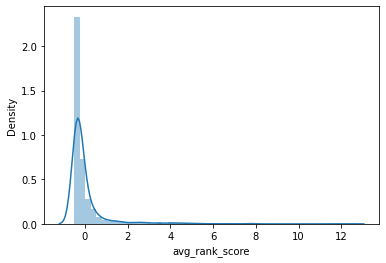

In [439]:
pop_metrics = pop_metrics_basic
pop_metrics[pop_metrics.columns] = StandardScaler().fit_transform(pop_metrics)

sns.distplot(pop_metrics['avg_rank_score'])
pp_x = data_df
pp_met = pop_metrics
pop_metrics

<AxesSubplot:xlabel='avg_rank_score', ylabel='Density'>

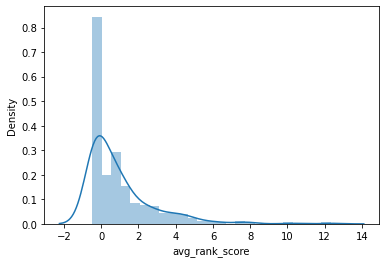

In [440]:
from sklearn.utils import shuffle

pop_metrics['sen_range'] = pop_metrics['avg_rank_score'].apply(lambda x: 1 if x >= 0.5 else 0)
pp_met_pos = pop_metrics[pop_metrics['sen_range'] == 1]
pp_met_neg = shuffle(pop_metrics[pop_metrics['sen_range'] == 0]).head(len(pp_met_pos))
pp_met = pd.concat([pp_met_pos, pp_met_neg])
pp_x = data_df.iloc[pp_met.index]

sns.distplot(pp_met['avg_rank_score'])

# sns.countplot(pp_met['sen_range'])
# y_col = 'sensationality'
# y = data_df.pop(y_col)

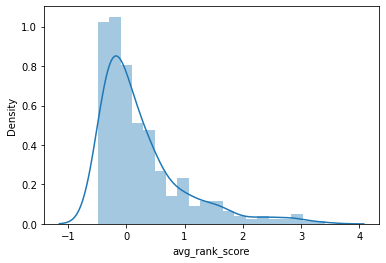

In [441]:
x = np.sort(pop_metrics['avg_rank_score'])
f_x = np.gradient(x)*np.exp(-x**2/2)
sample_probs = f_x/np.sum(f_x)
# samples = np.random.choice(x, p=sample_probs, size=1000000)
df_samples = pop_metrics["avg_rank_score"].sort_values().sample(
    n=400,
    weights=sample_probs,
    replace=False,
)

sns.distplot(df_samples)
# df_samples
pp_met = pop_metrics.iloc[df_samples.index]
pp_x = data_df.iloc[df_samples.index]
# song_billboard_names = songs_df[df_samples.index]

# pop_metrics[pop_metrics["sensationality"] > 0]

Processed 2485 models on 2 predictors in 43.41655898094177 seconds.
mse: 0.566787891094273


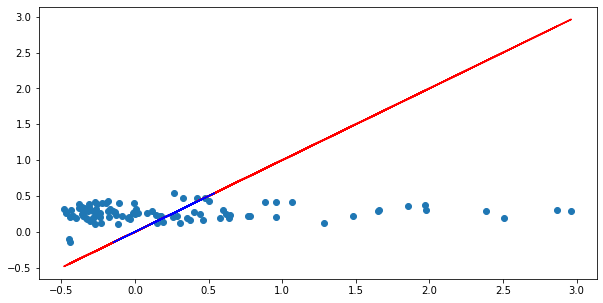

In [447]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
import itertools
import time

def gscv(mdl, param_grid, x_, y_, score_method, verbose=0):
    grid_search = GridSearchCV(mdl, param_grid=param_grid, n_jobs=-1, verbose=verbose, scoring=score_method)
    grid_search.fit(x_, y_)
    if verbose == 1:
        print(f"best params = {grid_search.best_params_}")
        print(f"best score = {grid_search.best_score_}")
    return grid_search.best_params_

# pop_metrics = [pop_metrics_basic, pop_metrics_classic, pop_metrics_score_01, pop_metrics_score_02]
# for pms in pop_metrics:
#     ln = LinearRegression()
#     param_map = {"y": [pms[pm] for pm in pms.columns]}
#     print(gscv(ln, param_map, data_df.values, score_method='neg_root_mean_squared_error'))

def process_subset(model, X, y, features):
    kf = KFold()
    mse = []
    X = X[list(features)]
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        regr = model.fit(X_train, y=y_train)
        y_predict = regr.predict(X_test)
        mse.append(mean_squared_error(y_test, y_predict))
    return {"model": model, "features": features, "MSE":np.mean(mse)}

def best_subset(model, X, y, subset_size=-1, force=False):
    limit = 100000
    if subset_size == -1:
        subset_size = len(X.columns)
    assert len(X.columns) >= subset_size, f"X.columns must be >= subset_size. Given len(X.columns)={len(X.columns)}, subset_size={subset_size}"

    num_combinations = np.math.factorial(len(X.columns))/(np.math.factorial(len(X.columns)-subset_size) * np.math.factorial(subset_size))
    if num_combinations > limit and not force:
        print(f"Please be aware that this action run {int(num_combinations)} models and there is a real possibility it will crash your machine.\nIf you're sure you want to do this please include the parameter 'force=True' when calling this function")
        return {"model": model, "features": X.columns, "MSE": -1}
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, subset_size):
        results.append(process_subset(model, X, y, combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['MSE'].argmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", subset_size, "predictors in", (toc-tic), "seconds.")
    return best_model

# def forward(model, X, y, staring_predictors):
#     remaining_predictors = [p for p in X.columns if p not in staring_predictors]
#     tic = time.time()
#     results = []
#     for p in remaining_predictors:
#         results.append(process_subset(model, X, y, staring_predictors+[p]))
#     models = pd.DataFrame(results)
#     best_model = models.loc[models['MSE'].argmin()]
#     toc = time.time()
#     print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
#
#     Return the best model, along with some other useful information about the model
    # return best_model

# all_features = ['duration_ms', 'key', 'energy', 'loudness', 'danceability', 'speechiness', 'instrumentalness', 'tempo']
pp_x = pp_x.filter(regex=('^((?!mfcc).)*$'))

best_model = best_subset(LinearRegression(), pp_x, pp_met['avg_rank_score'], 2)
# print(f"Best Features: f{best_model['features']}")
x_train, x_test, y_train, y_test = train_test_split(pp_x[list(best_model['features'])], pp_met['avg_rank_score'])
mdl = LinearRegression().fit(x_train, y_train)
y_pred = mdl.predict(x_test)
print(f"mse: {mean_squared_error(y_test, y_pred)}")

fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
plt.plot(y_test,y_test,'r', label='test')
plt.plot(y_pred,y_pred,'b', label='pred')

In [443]:
data_df.iloc[0]

duration_ms            0.796196
danceability          -2.178146
energy                 0.030618
key                    0.513133
loudness              -0.277509
                         ...   
mean_segment_timbre    1.000000
var_segment_timbre    -1.000000
num_tatums             0.000000
mean_tatum_duration   -1.000000
var_tatum_duration     1.000000
Name: 0, Length: 111, dtype: float64

In [444]:
song_billboard_names[500]

'Mood Swings'

In [445]:
pp_met['sensationality'][400]

1.3959902776560005

In [446]:
mdl.predict([data_df.iloc[600]])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 71 is different from 111)

In [456]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, svd_solver='full')
pca_data = pca.fit_transform(data_df)

pca_comp = pd.DataFrame(pca.components_, index=pca_data.index)
pca_comp.style.background_gradient(vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True))
pca_comp.index

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [449]:
pca_comp

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,-0.045248,0.115763,-0.013466,-0.004438,0.004186,-0.041175,0.127744,-0.061409,-0.016082,0.007374,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,0.020004,-0.087570,-0.130894,0.007010,-0.105855,-0.003493,-0.071471,0.174818,0.013865,-0.029135,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,0.035402,-0.021307,-0.162006,-0.027995,-0.134008,-0.010706,0.021555,0.074421,0.045471,-0.019159,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,0.072021,-0.093834,0.038387,-0.037840,0.077072,0.048816,-0.156800,-0.063901,-0.030187,-0.034880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.032014,0.039427,-0.220735,-0.031251,-0.260376,0.009933,0.014319,0.062228,0.090181,-0.109755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.041651,-0.146245,-0.009126,0.026447,-0.124109,-0.025294,0.042129,0.069032,0.145676,0.166332,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6,0.036111,0.028764,0.244213,0.071715,0.241247,-0.037454,-0.115436,-0.134949,-0.085279,-0.026920,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,0.015127,-0.136048,-0.255151,-0.063128,-0.267362,0.111666,0.003110,0.168861,0.125068,0.051478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.012961,-0.133148,-0.046304,0.159317,-0.128334,0.193294,-0.150006,0.068354,0.291535,-0.037769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.243541,0.215924,-0.072438,0.325103,-0.109664,-0.231688,0.165315,0.093639,0.225038,0.152254,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [ ]:
# y = pp_met.iloc[pca_comp.index]
# # print(y.shape)
# print(pca_comp)
# x_train, x_test, y_train, y_test = train_test_split(pca_data, y)
# mdl = LinearRegression().fit(x_train, y_train)
# y_pred = mdl.predict(x_test)
# print(f"mse: {mean_squared_error(y_test, y_pred)}")
#
# fig = plt.figure(figsize=(10,5))
# plt.scatter(y_test,y_pred)
# plt.plot(y_test,y_test,'r', label='test')
# plt.plot(y_pred,y_pred,'b', label='pred')

In [ ]:
pca_data

1. All 111 or 71 if mfccs are left out
2. 1 model with forward regression
3. 1 model with backward regression
4. best 2 models with best subset with len=avg(forward and backward)
5. Limit our initial feature set => data visualisations and exploration